In [10]:
import os

# List files in the working directory
print(os.listdir("/kaggle/working/"))

['data', '.virtual_documents']


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import pickle
import numpy as np
import copy

In [12]:
###############################################################################
# 1. Data Preparation: CIFAR-10 + Cutout
###############################################################################
class Cutout:
    """
    Randomly masks out square regions of an image. Assumes the input is a tensor.
    """
    def __init__(self, n_holes=1, length=16):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        img: tensor image of size (C, H, W)
        """
        h = img.size(1)
        w = img.size(2)

        # Create a mask full of 1s
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask).to(img.device)
        mask = mask.expand_as(img)
        img = img * mask
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(n_holes={self.n_holes}, length={self.length})'


def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=16),
        transforms.Normalize(mean, std),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    return train_loader, test_loader

In [13]:
###############################################################################
# 2. Narrow ResNet-34 Implementation
###############################################################################
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding, no bias."""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride,
        padding=1, bias=False
    )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, bn_momentum=0.9):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


class NarrowResNet34(nn.Module):
    def __init__(self, num_classes=10, width_multiplier=0.75,
                 bn_momentum=0.9, dropout=0.0):
        """
        ResNet-34 with fewer channels (width_multiplier) and optional dropout.
        """
        super(NarrowResNet34, self).__init__()
        self.block_layers = [3, 4, 6, 3]
        base_channels = [64, 128, 256, 512]
        self.channels = [int(c * width_multiplier) for c in base_channels]
        self.in_planes = self.channels[0]

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)

        # Stages
        self.layer1 = self._make_layer(self.channels[0], self.block_layers[0],
                                       stride=1, bn_momentum=bn_momentum)
        self.layer2 = self._make_layer(self.channels[1], self.block_layers[1],
                                       stride=2, bn_momentum=bn_momentum)
        self.layer3 = self._make_layer(self.channels[2], self.block_layers[2],
                                       stride=2, bn_momentum=bn_momentum)
        self.layer4 = self._make_layer(self.channels[3], self.block_layers[3],
                                       stride=2, bn_momentum=bn_momentum)

        # Global average pooling + dropout + linear
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.channels[3] * BasicBlock.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, planes, blocks, stride=1, bn_momentum=0.9):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(planes, momentum=bn_momentum),
            )

        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride, downsample,
                                 bn_momentum=bn_momentum))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes, bn_momentum=bn_momentum))
        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)
        return x


In [14]:
###############################################################################
# 3. Training and Evaluation Routines
###############################################################################
def train_one_epoch(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, device, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


In [15]:
###############################################################################
# 4. Structured Pruning Utilities
###############################################################################
def get_conv_layers(model):
    """
    Return a list of (module, downsample_module_if_any) for each residual block's conv layers.
    We'll also get the matching downsample if it exists, so we can prune it consistently.
    """
    conv_layers = []

    def check_downsample_for_conv(ds):
        # If downsample is None or doesn't have a conv2d, return None
        if ds is None:
            return None
        for m in ds.modules():
            if isinstance(m, nn.Conv2d):
                return m
        return None

    
    def find_convs_in_sequential(seq):
        for block in seq:
            if isinstance(block, BasicBlock):
                # block.conv1, block.conv2, possibly block.downsample
                conv_layers.append((block.conv1, check_downsample_for_conv(block.downsample)))
                conv_layers.append((block.conv2, None))  # conv2 typically doesn't have a new downsample
            else:
                pass

    find_convs_in_sequential(model.layer1)
    find_convs_in_sequential(model.layer2)
    find_convs_in_sequential(model.layer3)
    find_convs_in_sequential(model.layer4)

    return conv_layers

def compute_channel_importance(model, device):
    """
    For each Conv2d layer, compute the L1 norm of each output channel's weights.
    We'll store them in a list with the shape: layer_importance[i] = (conv, [c0_norm, c1_norm, ...]).
    """
    convs = get_conv_layers(model)
    layer_importance = []

    for (conv, ds_conv) in convs:
        w = conv.weight.data.abs().sum(dim=(1,2,3))  # L1 norm per out_channel
        layer_importance.append((conv, ds_conv, w.cpu().numpy()))
    return layer_importance

def pick_channels_to_keep(importance, prune_ratio):
    """
    Given a vector of channel importances, pick the top-K channels to keep based on L1 norm.
    If prune_ratio=0.3, we keep 70% channels with the largest norms.
    Returns an array of indices (sorted ascending) of the channels to keep.
    """
    num_channels = len(importance)
    k = int(num_channels * (1 - prune_ratio))
    if k < 1:
        k = 1
    # Sort channels by descending importance
    sorted_indices = np.argsort(-importance)  # descending
    keep = sorted_indices[:k]
    keep = np.sort(keep)  # for convenience
    return keep

def build_pruned_conv(old_conv, keep_indices, in_channels_to_keep=None):
    """
    Create a new nn.Conv2d with fewer out_channels (and optionally fewer in_channels),
    and copy the relevant weights from `old_conv`.
    - keep_indices: which output channels to keep
    - in_channels_to_keep: which input channels to keep (None => keep all)
    """
    old_weight = old_conv.weight.data
    out_channels = len(keep_indices)

    if in_channels_to_keep is None:
        in_channels_to_keep = range(old_weight.shape[1])

    new_conv = nn.Conv2d(
        in_channels=len(in_channels_to_keep),
        out_channels=out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        dilation=old_conv.dilation,
        groups=1,  
        bias=(old_conv.bias is not None)
    )

    # Copy weights
    with torch.no_grad():
        for new_i, old_i in enumerate(keep_indices):
            for new_j, old_j in enumerate(in_channels_to_keep):
                new_conv.weight[new_i, new_j] = old_weight[old_i, old_j]

        if old_conv.bias is not None:
            old_bias = old_conv.bias.data
            new_conv.bias.data = old_bias[keep_indices].clone()

    return new_conv

In [16]:
def prune_model_structured(model, prune_ratio=0.3, device='cuda'):
    """
    1) Compute channel importance for each conv layer.
    2) Decide which channels to keep in each layer.
    3) Rebuild the entire model with fewer channels.
    4) Copy weights.

    Returns the pruned model.
    """
    model = copy.deepcopy(model).to(device)  # copy to avoid in-place modification
    model.eval()

    layer_importance = compute_channel_importance(model, device)
    # layer_importance is a list of (conv, ds_conv, w_array)

    # store for each layer:
    # - which out_channels we keep
    
    keep_out_channels = []
    for (conv, ds_conv, w) in layer_importance:
        out_keep = pick_channels_to_keep(w, prune_ratio)
        keep_out_channels.append((conv, ds_conv, out_keep))

    # build a new model with the pruned structure
    # 1) Start from the existing model
    pruned_model = NarrowResNet34(
        num_classes=model.fc.out_features,
        width_multiplier=1.0,   # We'll override channel counts manually
        bn_momentum=0.9,
        dropout=model.dropout.p if isinstance(model.dropout, nn.Dropout) else 0.0
    ).to(device)

    # gather all conv references
    old_convs = get_conv_layers(model)
    new_convs = get_conv_layers(pruned_model)

    # handle the very first conv1:
    old_first_conv = model.conv1
    new_first_conv = pruned_model.conv1

    # store the in_channels that go into each block's conv
    prev_keep = range(old_first_conv.weight.shape[1])  # initially keep all RGB
    # prune the first conv1 output channels
    first_out_channels = old_first_conv.weight.shape[0]
    w_first = old_first_conv.weight.data.abs().sum(dim=(1,2,3)).cpu().numpy()
    keep_first = pick_channels_to_keep(w_first, prune_ratio)

    # Rebuild conv1
    pruned_conv1 = build_pruned_conv(old_first_conv, keep_first, in_channels_to_keep=prev_keep)
    pruned_model.conv1 = pruned_conv1

    # update new_first_conv BN
    old_bn1 = model.bn1
    new_bn1 = pruned_model.bn1
    with torch.no_grad():
        new_bn1.weight.data = old_bn1.weight.data[keep_first].clone()
        new_bn1.bias.data = old_bn1.bias.data[keep_first].clone()
        new_bn1.running_mean = old_bn1.running_mean[keep_first].clone()
        new_bn1.running_var = old_bn1.running_var[keep_first].clone()

    current_in_channels = keep_first  # for the next block

    # keep_out_channels is parallel to old_convs
    for i, ((old_conv, old_ds_conv), (conv, ds_conv, out_keep)) in enumerate(zip(old_convs, keep_out_channels)):
        (new_conv, new_ds_conv) = new_convs[i]

        # Build the pruned conv for the main branch
        pruned_conv = build_pruned_conv(old_conv, out_keep, in_channels_to_keep=current_in_channels)
        # Replace it in the new model
        # "old_conv" is a reference inside a BasicBlock,
        new_conv.weight = nn.Parameter(pruned_conv.weight.data.clone())
        if pruned_conv.bias is not None:
            new_conv.bias = nn.Parameter(pruned_conv.bias.data.clone())

        # Also, copy BN
        old_bn = None
        # We can find the BN by walking upward in the parent block.
        # We'll do it by direct attribute search in the BasicBlock
        old_block = find_parent_block(model, old_conv)
        new_block = find_parent_block(pruned_model, new_conv)
        if old_block is not None and new_block is not None:
            if old_block.conv1 is old_conv:
                old_bn = old_block.bn1
                new_bn = new_block.bn1
            elif old_block.conv2 is old_conv:
                old_bn = old_block.bn2
                new_bn = new_block.bn2

            if old_bn is not None:
                with torch.no_grad():
                    new_bn.weight.data = old_bn.weight.data[out_keep].clone()
                    new_bn.bias.data = old_bn.bias.data[out_keep].clone()
                    new_bn.running_mean = old_bn.running_mean[out_keep].clone()
                    new_bn.running_var = old_bn.running_var[out_keep].clone()

        # If there's a downsample conv, we prune it the same way
        if old_ds_conv is not None:
            ds_out_keep = out_keep 
            pruned_ds_conv = build_pruned_conv(old_ds_conv, ds_out_keep, in_channels_to_keep=current_in_channels)

            # Now replace the new model's downsample conv
            new_ds_block = find_downsample_block(pruned_model, new_block)
            if new_ds_block is not None:
                for m in new_ds_block.modules():
                    if isinstance(m, nn.Conv2d):
                        m.weight = nn.Parameter(pruned_ds_conv.weight.data.clone())
                        if pruned_ds_conv.bias is not None:
                            m.bias = nn.Parameter(pruned_ds_conv.bias.data.clone())

                # Copy BN as well
                old_ds_bn = find_downsample_bn(old_block)
                new_ds_bn = find_downsample_bn(new_block)
                if old_ds_bn is not None and new_ds_bn is not None:
                    with torch.no_grad():
                        new_ds_bn.weight.data = old_ds_bn.weight.data[ds_out_keep].clone()
                        new_ds_bn.bias.data = old_ds_bn.bias.data[ds_out_keep].clone()
                        new_ds_bn.running_mean = old_ds_bn.running_mean[ds_out_keep].clone()
                        new_ds_bn.running_var = old_ds_bn.running_var[ds_out_keep].clone()

            # The output channels of this block is the same "out_keep"
            current_in_channels = out_keep
        else:
            # No downsample => the output shape is out_keep
            current_in_channels = out_keep

    old_fc = model.fc
    new_fc = pruned_model.fc
    last_keep = current_in_channels  # channels from the final conv block
    in_features = len(last_keep)
    # Build a new fc
    new_fc2 = nn.Linear(in_features, old_fc.out_features).to(device)
    # Copy weights
    with torch.no_grad():
        for new_i, old_i in enumerate(last_keep):
            new_fc2.weight[:, new_i] = old_fc.weight[:, old_i]
        new_fc2.bias[:] = old_fc.bias[:]

    pruned_model.fc = new_fc2

    # Now we can check param count
    return pruned_model


In [17]:
def find_parent_block(model, conv):
    """
    Given a model and a conv layer, try to find the BasicBlock that owns it.
    """
    for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
        layer = getattr(model, layer_name)
        for block in layer:
            if isinstance(block, BasicBlock):
                if block.conv1 is conv or block.conv2 is conv:
                    return block
    return None

def find_downsample_block(model, block):
    """
    Return block.downsample if it exists. We can't do block.downsample directly
    because we only have the 'new_block' from the pruned model. We'll just return block.downsample
    if it exists. This function is used after we find the parent block in the pruned model.
    """
    if hasattr(block, 'downsample'):
        return block.downsample
    return None

def find_downsample_bn(old_block):
    if old_block is None or old_block.downsample is None:
        return None
    for m in old_block.downsample.modules():
        if isinstance(m, nn.BatchNorm2d):
            return m
    return None

In [18]:
###############################################################################
# 4. Main Script: Training Loop with ResNet-34
###############################################################################
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

# Hyperparameters
batch_size = 128
initial_lr = 0.1
weight_decay = 5e-4
num_epochs_preprune = 200  
num_epochs_finetune = 50  

# 1) Load Data
train_loader, test_loader = get_cifar10_dataloaders(batch_size=batch_size)

# 2) Create Model and Train
model = NarrowResNet34(
        num_classes=10,
        width_multiplier=0.75,   # yields >5M params if not pruned
        bn_momentum=0.9,
        dropout=0.5
    ).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Unpruned model param count: {total_params:,}")

# Train for some epochs
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(
        model.parameters(), lr=initial_lr, momentum=0.9,
        weight_decay=weight_decay, nesterov=True
    )
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=180, eta_min=0.0
)

train_losses = []
train_accuracies = []
train_lrs = []

test_losses = []
test_accuracies = []

# Stage A: Train unpruned
for epoch in range(num_epochs_preprune):
    train_loss, train_acc = train_one_epoch(model, device, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, device, test_loader, criterion)
    lr_scheduler.step()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"[Preprune] Epoch {epoch+1}/{num_epochs_preprune} "
                f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")



Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Unpruned model param count: 11,975,674
[Preprune] Epoch 1/200 Train Acc: 10.17%, Test Acc: 10.85%
[Preprune] Epoch 2/200 Train Acc: 11.37%, Test Acc: 15.42%
[Preprune] Epoch 3/200 Train Acc: 14.39%, Test Acc: 23.11%
[Preprune] Epoch 4/200 Train Acc: 22.54%, Test Acc: 33.49%
[Preprune] Epoch 5/200 Train Acc: 28.67%, Test Acc: 42.61%
[Preprune] Epoch 6/200 Train Acc: 35.95%, Test Acc: 47.06%
[Preprune] Epoch 7/200 Train Acc: 44.01%, Test Acc: 58.50%
[Preprune] Epoch 8/200 Train Acc: 49.77%, Test Acc: 64.09%
[Preprune] Epoch 9/200 Train Acc: 54.24%, Test Acc: 67.78%
[Preprune] Epoch 10/200 Train Acc: 58.00%, Test Acc: 67.45%
[Preprune] Epoch 11/200 Train Acc: 60.45%, Test Acc: 72.60%
[Preprune] Epoch 12/200 Train Acc: 62.72%, Test Acc: 74.92%
[Preprune] Epoch 13/200 Train Acc: 64.04%, Test Acc: 73.45%
[Preprune] Epoch 14/200 Train Acc: 65.22%, Test Acc: 77.38%
[Preprune] Epoch 15/200 Train Acc: 

In [19]:

import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracies(train_accuracies, test_accuracies):
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(test_accuracies, label='Test Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.title('Accuracy vs. No. of epochs')

def plot_losses(train_losses, test_losses):
  plt.plot(train_losses, label='Train Losses')
  plt.plot(test_losses, label='Test Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.title('Loss vs. No. of epochs')

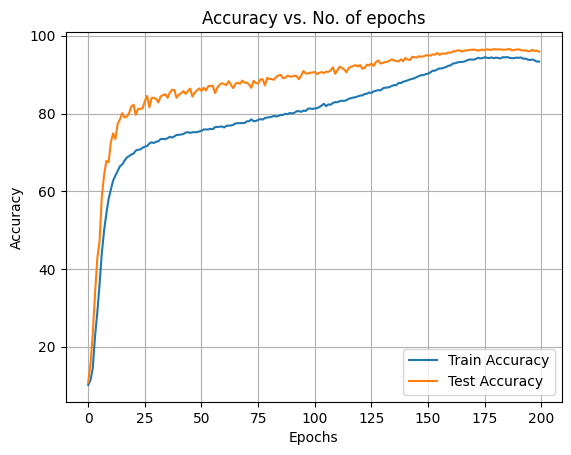

In [20]:
plot_accuracies(train_accuracies, test_accuracies)

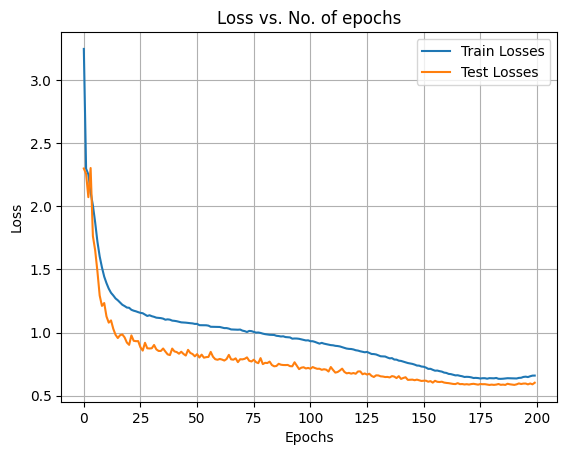

In [21]:
plot_losses(train_losses, test_losses)

In [27]:
# 3) Structured Pruning
prune_ratio = 0.38  # keep 40% of each layer's output channels
pruned_model = prune_model_structured(model, prune_ratio=prune_ratio, device=device)
pruned_model.to(device)
pruned_model.eval()

# Check parameter count again
pruned_params = sum(p.numel() for p in pruned_model.parameters())
print(f"Pruned model param count: {pruned_params:,}")

# 4) Fine-tune pruned model
# typically you do a smaller LR
ft_lr = 0.01
ft_optimizer = optim.SGD(
    pruned_model.parameters(), lr=ft_lr, momentum=0.9,
    weight_decay=weight_decay, nesterov=True
)
ft_scheduler = optim.lr_scheduler.StepLR(ft_optimizer, step_size=5, gamma=0.1)

train_losses_fine = []
train_accuracies_fine = []

test_losses_fine = []
test_accuracies_fine = []

for epoch in range(num_epochs_finetune):
    train_loss, train_acc = train_one_epoch(pruned_model, device, train_loader, criterion, ft_optimizer)
    test_loss, test_acc = evaluate(pruned_model, device, test_loader, criterion)
    ft_scheduler.step()
    
    train_losses_fine.append(train_loss)
    train_accuracies_fine.append(train_acc)
    test_losses_fine.append(test_loss)
    test_accuracies_fine.append(test_acc)
    
    print(f"[Finetune] Epoch {epoch+1}/{num_epochs_finetune} "
          f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

# Final Test
final_test_loss, final_test_acc = evaluate(pruned_model, device, test_loader, criterion)
print(f"\nFinal pruned model test accuracy: {final_test_acc:.2f}%")


Pruned model param count: 4,597,243
[Finetune] Epoch 1/50 Train Acc: 39.97%, Test Acc: 62.40%
[Finetune] Epoch 2/50 Train Acc: 58.04%, Test Acc: 70.98%
[Finetune] Epoch 3/50 Train Acc: 64.48%, Test Acc: 77.02%
[Finetune] Epoch 4/50 Train Acc: 67.75%, Test Acc: 78.36%
[Finetune] Epoch 5/50 Train Acc: 70.04%, Test Acc: 80.44%
[Finetune] Epoch 6/50 Train Acc: 74.41%, Test Acc: 85.14%
[Finetune] Epoch 7/50 Train Acc: 75.86%, Test Acc: 85.50%
[Finetune] Epoch 8/50 Train Acc: 76.61%, Test Acc: 85.97%
[Finetune] Epoch 9/50 Train Acc: 77.37%, Test Acc: 86.36%
[Finetune] Epoch 10/50 Train Acc: 77.60%, Test Acc: 86.22%
[Finetune] Epoch 11/50 Train Acc: 78.23%, Test Acc: 86.59%
[Finetune] Epoch 12/50 Train Acc: 78.22%, Test Acc: 87.06%
[Finetune] Epoch 13/50 Train Acc: 78.56%, Test Acc: 86.72%
[Finetune] Epoch 14/50 Train Acc: 78.48%, Test Acc: 87.09%
[Finetune] Epoch 15/50 Train Acc: 78.52%, Test Acc: 86.93%
[Finetune] Epoch 16/50 Train Acc: 78.59%, Test Acc: 87.19%
[Finetune] Epoch 17/50 Train 

In [28]:
def plot_accuracies(train_accuracies, test_accuracies):
  plt.plot(train_accuracies, label='Train Accuracy')
  plt.plot(test_accuracies, label='Test Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.title('Accuracy vs. No. of epochs after Finetuning')

def plot_losses(train_losses, test_losses):
  plt.plot(train_losses, label='Train Losses')
  plt.plot(test_losses, label='Test Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.title('Loss vs. No. of epochs after Finetuning')

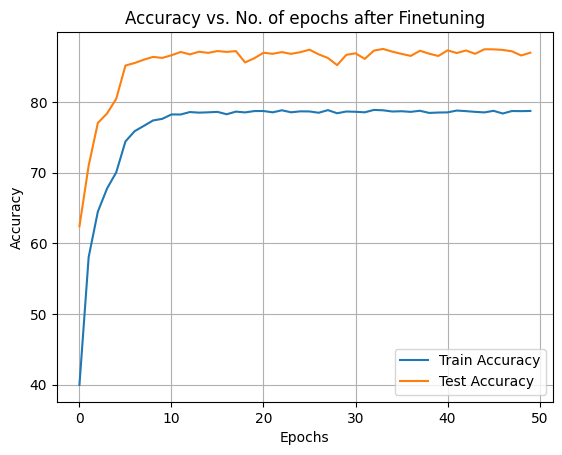

In [29]:
plot_accuracies(train_accuracies_fine, test_accuracies_fine)

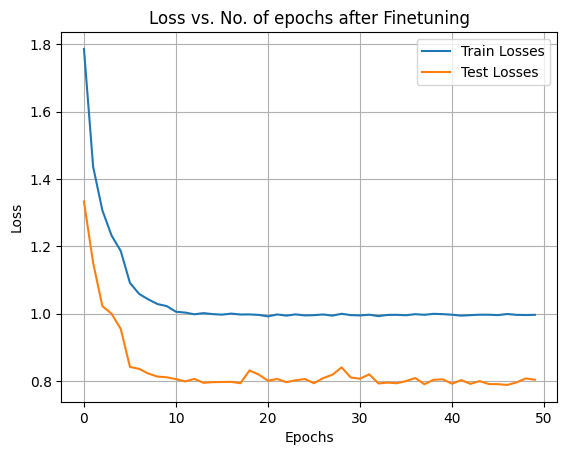

In [30]:
plot_losses(train_losses_fine, test_losses_fine)

In [31]:
# Save the trained model weights
torch.save(model, "/kaggle/working/resnet18_v1.pth")
print("Model saved to resnet18_v1.pth")

torch.save(model.state_dict(), "/kaggle/working/resnet18_v1_state.pth")
print("Model saved to resnet18_v1_state.pth")

Model saved to resnet18_v1.pth
Model saved to resnet18_v1_state.pth


In [32]:
#import pickle

#import torch
import pandas as pd
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

########################################################################
# 1) Set up Device
########################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

########################################################################
# 2) Load and Convert the Test File
########################################################################
def load_custom_test_set(filepath):
    # Open the pickle file and load the data
    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    
    # Extract image data
    images = data[b'data']  # Shape: (10000, 32, 32, 3)
    
    #Fix Shape: Convert (32, 32, 3) → (3, 32, 32)
    images = np.transpose(images, (0, 3, 1, 2))  # New shape: (10000, 3, 32, 32)
    
    # Convert data to float32
    images = images.astype(np.float32) / 255.0  # Normalize to [0,1]
    
    # Convert to a PyTorch tensor
    images = torch.tensor(images, dtype=torch.float32)
    
    return images

# Load test images from the provided file path.
test_images = load_custom_test_set("/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl")
print("Loaded custom test set with shape:", test_images.shape)  # e.g., (10000, 3, 32, 32)

########################################################################
# 3) Normalize Test Images
########################################################################
# Use the same normalization as in training.
pkl_mean = [0.4914, 0.4822, 0.4465]
pkl_std = [0.263, 0.260, 0.273]

normalize = transforms.Normalize(mean=pkl_mean, std=pkl_std)

def preprocess_images(images):
    # Loop over each image to apply normalization
    for i in range(images.shape[0]):
        images[i] = normalize(images[i])
    return images

test_images = preprocess_images(test_images)

########################################################################
# 4) Create DataLoader for Test Set
########################################################################
test_dataset = torch.utils.data.TensorDataset(test_images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, bn_momentum=0.9):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class NarrowResNet34(nn.Module):
    def __init__(self, num_classes=10, width_multiplier=0.75,
                 bn_momentum=0.9, dropout=0.5):
        """
        ResNet-34 with fewer channels (width_multiplier) and optional dropout.
        """
        super(NarrowResNet34, self).__init__()
        # ResNet-34 basic configuration is: [3, 4, 6, 3]
        self.block_layers = [3, 4, 6, 3]

        base_channels = [64, 128, 256, 512]
        self.channels = [int(c * width_multiplier) for c in base_channels]
        self.in_planes = self.channels[0]

        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)

        # Stages
        self.layer1 = self._make_layer(self.channels[0], self.block_layers[0], stride=1, bn_momentum=bn_momentum)
        self.layer2 = self._make_layer(self.channels[1], self.block_layers[1], stride=2, bn_momentum=bn_momentum)
        self.layer3 = self._make_layer(self.channels[2], self.block_layers[2], stride=2, bn_momentum=bn_momentum)
        self.layer4 = self._make_layer(self.channels[3], self.block_layers[3], stride=2, bn_momentum=bn_momentum)

        # Global average pooling + dropout + linear
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.channels[3] * BasicBlock.expansion, num_classes)

        self._init_weights()

    def _make_layer(self, planes, blocks, stride=1, bn_momentum=0.9):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes, momentum=bn_momentum),
            )

        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride, downsample, bn_momentum=bn_momentum))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes, bn_momentum=bn_momentum))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)  # Dropout before final FC
        x = self.fc(x)
        return x




model = NarrowResNet34(width_multiplier=0.75,num_classes=10,bn_momentum=0.9, dropout=0.5).to(device)

########################################################################
# 6) Load the Saved Model Weights
########################################################################
import os
weights_path = "/kaggle/working/resnet18_v1_state.pth"  
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    print("Loaded model weights from", weights_path)
else:
    print("Weights file not found. Using the current model in memory.")

model.eval()

########################################################################
# 7) Run Inference on the Test Set
########################################################################
all_predictions = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_predictions.extend(predicted.cpu().numpy())

########################################################################
# 8) Create Submission CSV File
########################################################################
submission = pd.DataFrame({
    'ID': np.arange(len(all_predictions)),
    'Labels': all_predictions
})
submission.to_csv('/kaggle/working/submission_v1.csv', index=False)
print("Submission file saved as submission_v1.csv")

Using device: cuda
Loaded custom test set with shape: torch.Size([10000, 3, 32, 32])


<ipython-input-32-34ea95717bed>:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


Loaded model weights from /kaggle/working/resnet18_v1_state.pth
Submission file saved as submission_v1.csv
